In [1]:
import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import urllib.request as req
plt.style.use('fivethirtyeight')

D:\oneNeuron\Pytorch\Pytorch-basics\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download data

In [2]:
data_URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [3]:
# create a directory
def create_dirs(dir_path):
    os.makedirs(dir_path, exist_ok=True)
    print(f"{dir_path} directory created")
    
ROOT_DATA_DIR = "hymenoptera_data"
create_dirs(ROOT_DATA_DIR)

hymenoptera_data directory created


In [4]:
data_zip_file = "data.zip"
data_zip_path = os.path.join(ROOT_DATA_DIR, data_zip_file)

if not os.path.isfile(data_zip_file):
    print("downloading data...")
    filename, headers = req.urlretrieve(data_URL, data_zip_path)
    print(f"filename: {filename} created with info \n{headers}")
else:
    print(f"file is already present")

downloading data...
filename: hymenoptera_data\data.zip created with info 
Content-Type: application/zip
Content-Length: 47286322
Connection: close
Date: Fri, 11 Mar 2022 11:26:26 GMT
Last-Modified: Wed, 15 Mar 2017 18:46:00 GMT
ETag: "5f8c32a6554f6acb4d649776e7735e48"
x-amz-version-id: null
Accept-Ranges: bytes
Server: AmazonS3
X-Cache: Hit from cloudfront
Via: 1.1 940482e8695da5fdb5cf0f4bf9f97420.cloudfront.net (CloudFront)
X-Amz-Cf-Pop: BLR50-C1
X-Amz-Cf-Id: TXhxd-X7q_2ss6aOFcvGw-lnemoXUJiiRmxtPCeWquZTjllb23QFZg==
Age: 16918




## Unzip data

In [5]:
from zipfile import ZipFile

unzip_data_dirname = "unzip_data_dir"
unzip_data_dir = os.path.join(ROOT_DATA_DIR, unzip_data_dirname)

if not os.path.exists(unzip_data_dir):
    os.makedirs(unzip_data_dir, exist_ok=True)
    with ZipFile(data_zip_path) as f:
        f.extractall(unzip_data_dir)
else:
    print(f"data already extacted")

data already extacted


## Create data loaders

In [6]:
from pathlib import Path

In [7]:
train_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/train")
test_path = Path("hymenoptera_data/unzip_data_dir/hymenoptera_data/val")

In [8]:
img_size = (224, 224)

In [9]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

### Transformations

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [11]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_path, transform=test_transforms)

In [12]:
train_data.class_to_idx

{'ants': 0, 'bees': 1}

In [13]:
label_map = train_data.class_to_idx
label_map

{'ants': 0, 'bees': 1}

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\unzip_data_dir\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
           )

In [15]:
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [16]:
data = next(iter(train_loader))

In [17]:
len(data)

2

In [18]:
images, labels = data

In [19]:
images.shape

torch.Size([64, 3, 224, 224])

In [20]:
labels.shape

torch.Size([64])

## Download and use pre-trained model for transfer learning

In [21]:
model = models.alexnet(pretrained=True)

In [22]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
def count_both_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = {"trainable": 0, "non_trainable": 0}
    
    for name, parameters in model.named_parameters():
        param = parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"] += param
            continue
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total["trainable"] += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"""Total trainable: {total["trainable"]}, non trainable: {total["non_trainable"]} """)
    return df

count_both_params(model)

,Modules,Parameters
0,features.0.weight,23232
1,features.0.bias,64
2,features.3.weight,307200
3,features.3.bias,192
4,features.6.weight,663552
5,features.6.bias,384
6,features.8.weight,884736
7,features.8.bias,256
8,features.10.weight,589824
9,features.10.bias,256


In [24]:
# Freezing all the model layers
for parameters in model.parameters():
    parameters.requires_grad = False

In [25]:
count_both_params(model)

,Modules,Parameters


In [26]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [27]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=100, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=100, out_features=2, bias=True)
)

In [28]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Drop

In [29]:
count_both_params(model)

,Modules,Parameters
0,classifier.0.weight,921600
1,classifier.0.bias,100
2,classifier.3.weight,200
3,classifier.3.bias,2


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Training loop

In [31]:
num_epochs = 20

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())



In [32]:
for epoch in range(num_epochs):
    with tqdm(train_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tqdm_epoch.set_postfix(loss=loss.item())
            

Epoch 20/20: 100%|████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s, loss=0.025]


In [33]:
ROOT_MODEL_DIR = "Session_07_models"
os.makedirs(ROOT_MODEL_DIR, exist_ok=True)

MODEL_FILE = "Trans_model.pth"
MODEL_FILE_PATH = os.path.join(ROOT_MODEL_DIR, MODEL_FILE)


torch.save(model, MODEL_FILE_PATH)

## Evaluate our model

In [45]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_loader):
        image, label = data[0].to(device), data[1].to(device)
        
        y_pred = F.softmax(model(image), dim=1)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, label.cpu().numpy()))

<AxesSubplot:>

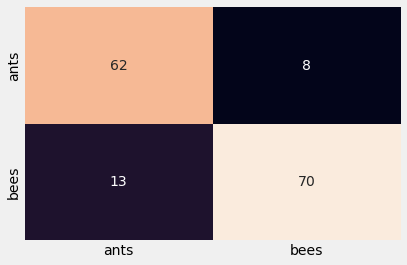

In [46]:
cm = confusion_matrix(target, pred)

# plt.figure(fi)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cbar=False)

## Prediction 

In [51]:
data = next(iter(test_loader))
data

[tensor([[[[ 0.6078,  0.5765,  0.7176,  ...,  0.4275,  0.3490,  0.2784],
           [ 0.4667,  0.5373,  0.6078,  ...,  0.4353,  0.4353,  0.3176],
           [ 0.5294,  0.5529,  0.4902,  ...,  0.3569,  0.3569,  0.3569],
           ...,
           [ 0.0980,  0.3490,  0.6941,  ...,  0.2392,  0.2863,  0.6078],
           [ 0.2863,  0.4588,  0.6157,  ...,  0.0667,  0.1059,  0.1922],
           [ 0.2706,  0.3961,  0.5294,  ...,  0.0275,  0.2549,  0.0902]],
 
          [[ 0.9216,  0.8275,  0.8980,  ...,  0.7412,  0.5686,  0.4667],
           [ 0.8353,  0.8745,  0.8980,  ...,  0.7490,  0.6314,  0.4902],
           [ 0.8196,  0.8588,  0.7961,  ...,  0.6706,  0.6157,  0.6157],
           ...,
           [ 0.3255,  0.4510,  0.8588,  ...,  0.3569,  0.4196,  0.7255],
           [ 0.5686,  0.6000,  0.8118,  ...,  0.1843,  0.2392,  0.2549],
           [ 0.5059,  0.6314,  0.7961,  ...,  0.1294,  0.4196,  0.1529]],
 
          [[ 0.9843,  0.8902,  0.9216,  ...,  0.7961,  0.6549,  0.4275],
           [ 

In [52]:
len(data)

2

In [53]:
images, labels = data

In [54]:
img = images[2]

In [55]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


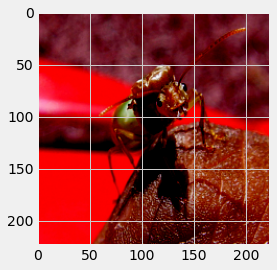

In [57]:
plt.imshow(img.permute(1,2,0))

$$normalized_data = (data - mean) / std$$

$$normalized_data * std = (data - mean)$$

$$normalized_data * std  + mean = data$$

In [58]:
img.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [59]:
img = img.unsqueeze(0).to(device)

pred_prob = F.softmax(model(img), dim=1)

In [63]:
argmax = torch.argmax(pred_prob).item()

In [65]:
inv_label_map = {val: key for key, val in label_map.items()}
inv_label_map

{0: 'ants', 1: 'bees'}

In [69]:
inv_label_map[argmax], inv_label_map[labels[2].item()]

('ants', 'ants')

In [75]:
pred_prob.cpu().data.squeeze().numpy()

array([0.99045193, 0.00954811], dtype=float32)

In [77]:
def prediction_viz(img, pred_prob, label_map, FIG_SIZE=(10, 15)):
    pred_prob = pred_prob.cpu().data.numpy().squeeze()
    
    _, (ax1, ax2) = plt.subplots(figsize=FIG_SIZE, ncols=2)
    
    # unnormalize the img
    img = img.cpu() * std[:, None, None] + mean[:, None, None]
    ax1.imshow(img.squeeze().permute(1,2,0).cpu())
    ax1.axis("off")
    
    ax2.barh(np.arange(2), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    
    ax2.set_yticklabels(label_map.keys(), size="small")
    ax2.set_title("pred prob")
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

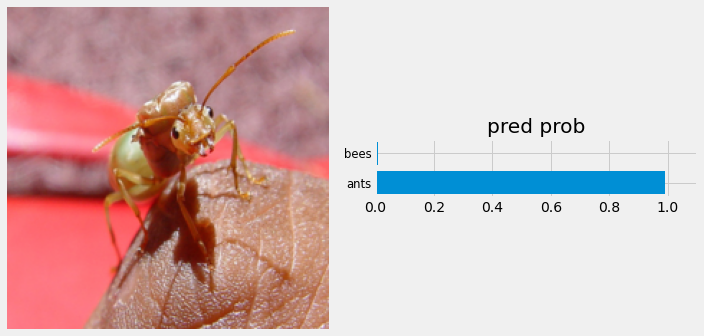

In [78]:
prediction_viz(img, pred_prob, label_map)